In [53]:
#Load the libraries to be used in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [54]:
#Load the data from the downloaded file
pylago_eikon_df = pd.read_csv('pyalgo_eikon_eod_data.csv', index_col=0,parse_dates=True).dropna()

In [55]:
pylago_eikon_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [56]:
#Convert the date column to datetime
pricing_data = pd.DataFrame(pylago_eikon_df['EUR='])
pricing_data.rename(columns={'EUR=':'Pricing'}, inplace = True)
pricing_data

,Pricing
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318
2010-01-08,1.4412
...,...
2019-12-24,1.1087
2019-12-26,1.1096
2019-12-27,1.1175


In [57]:
#Define a function to compute the simple moving average of the historic data
def simple_moving_average(data, window):
    sma = data.rolling(window = window).mean()
    return sma

#Set the number of days for the window
window = 200

#Run the simple_moving_average on the dataframe
pricing_data['SMA 200'] = simple_moving_average(pricing_data['Pricing'], window)

In [58]:
#Define a function to create Bollinger Bands from the data
def create_bands(data, sma, window):
    standard_deviation = data.rolling(window = window).std()
    upper_band = sma + standard_deviation * 2
    lower_band = sma - standard_deviation * 2
    return upper_band, lower_band

pricing_data['Upper Band'], pricing_data['Lower Band'] = create_bands(pricing_data['Pricing'], pricing_data['SMA 200'], 200)

In [59]:
pricing_data.tail()

,Pricing,SMA 200,Upper Band,Lower Band
Date,,,,
2019-12-24,1.1087,1.115027,1.137021,1.093033
2019-12-26,1.1096,1.114912,1.136779,1.093046
2019-12-27,1.1175,1.114849,1.136610,1.093088
2019-12-30,1.1197,1.114785,1.136413,1.093157
2019-12-31,1.1210,1.114722,1.136202,1.093242


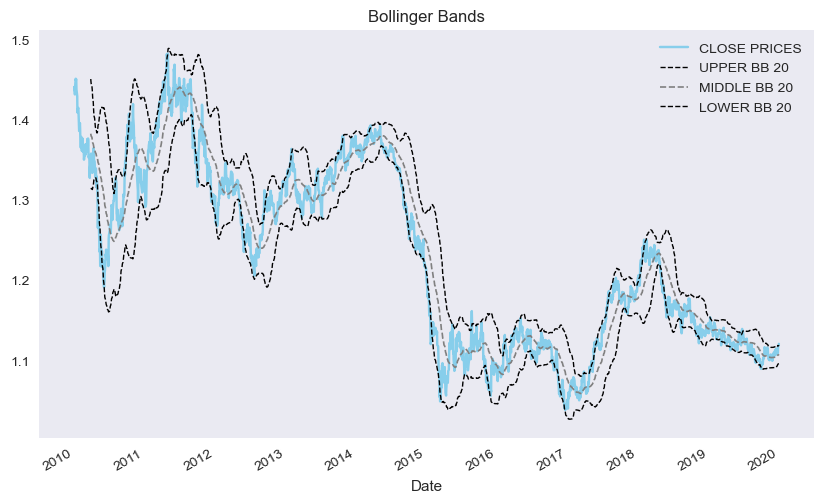

In [31]:
#Plot the figures with the bollinger bands
plt.figure(figsize=(10,6))
plt.title("Bollinger Bands")
pricing_data['Pricing'].plot(label = 'CLOSE PRICES', color = 'skyblue')
pricing_data['Upper Band'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
pricing_data['SMA 60'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
pricing_data['Lower Band'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [60]:
#Define a function to generate the trading signals

#If the condition to buy the stock gets satisfied, the buying price will be appended to the ‘buy_price’ list, 
#and the signal value will be appended as 1 representing to buy the stock

#If the condition to sell the stock gets satisfied, the buying price will be appended to the ‘sell_price’ list, 
#and the signal value will be appended as -1 representing to buy the stock

def implement_bands_strategy(data, lower_band, upper_band):
    buy_price = []
    sell_price = []
    bands_signal = []
    signal = 0
    
    for i in range(len(data)):
        if(data[i-1] > lower_band[i-1] and data[i] < lower_band[i]):
            if(signal != 1):
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        elif(data[i-1] < upper_band[i-1] and data[i] > upper_band[i]):
            if(signal != -1):
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bands_signal.append(0)
            
    return buy_price, sell_price, bands_signal

buy_price, sell_price, bands_signal = implement_bands_strategy(pricing_data['Pricing'], pricing_data['Lower Band'], pricing_data['Upper Band'])

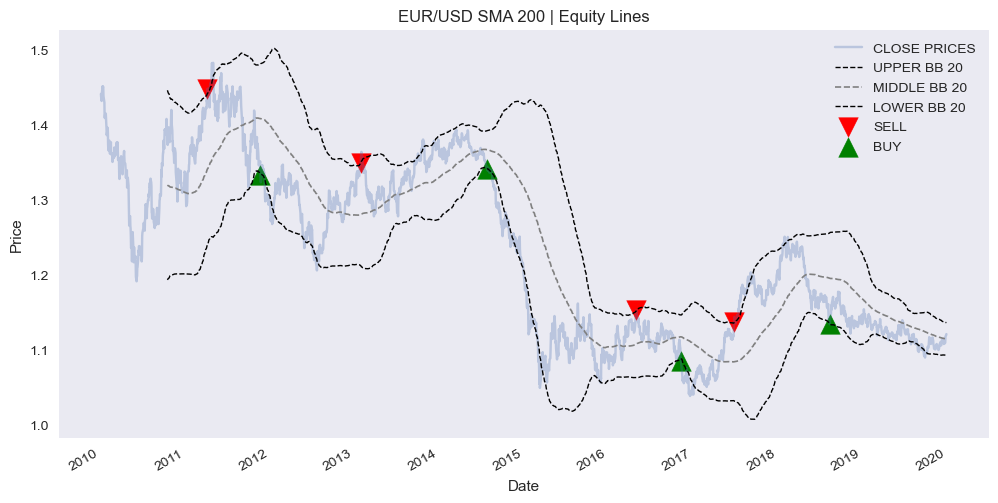

In [62]:
#Plot the figures with the trading signals
plt.figure(figsize = (12,6))
plt.title("EUR/USD SMA 200 | Equity Lines")
pricing_data['Pricing'].plot(label = 'CLOSE PRICES', alpha = 0.3)
pricing_data['Upper Band'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
pricing_data['SMA 200'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
pricing_data['Lower Band'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(pricing_data.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.scatter(pricing_data.index, buy_price, marker='^', color = 'green', label = 'BUY', s = 200)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper right')
plt.grid()
plt.show()

Create positions for our strategy

In [63]:
position = []
for i in range(len(bands_signal)):
    if bands_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(pricing_data['Pricing'])):
    if bands_signal[i] == 1:
        position[i] = 1
    elif bands_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]

In [51]:
pricing_data.drop(columns = ['Band Signals', 'Band Position'])

,Pricing,SMA 60,Upper Band,Lower Band,Returns,Strategy,Cummulative Strategy,Cummulative Returns,SMA 200
Date,,,,,,,,,
2010-01-04,1.4411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,1.4368,NaN,NaN,NaN,-0.002988,-0.002988,2.710183,0.997016,NaN
2010-01-06,1.4412,NaN,NaN,NaN,0.003058,0.003058,2.718470,1.000069,NaN
2010-01-07,1.4318,NaN,NaN,NaN,-0.006544,-0.006544,2.700796,0.993547,NaN
2010-01-08,1.4412,NaN,NaN,NaN,0.006544,0.006544,2.718470,1.000069,NaN
...,...,...,...,...,...,...,...,...,...
2019-12-24,1.1087,1.106538,1.137021,1.093033,0.000090,0.000090,2.023667,0.769343,1.115027
2019-12-26,1.1096,1.106815,1.136779,1.093046,0.000811,0.000811,2.024826,0.769967,1.114912
2019-12-27,1.1175,1.107177,1.136610,1.093088,0.007094,0.007094,2.035022,0.775449,1.114849


In [64]:
#Add the bands_signal list to the main dataset
pricing_data.insert(loc = 2,column = 'Band Signals', value = bands_signal)

#Add the positions list to the main dataset
pricing_data.insert(loc = 3,column = 'Band Position', value = position)

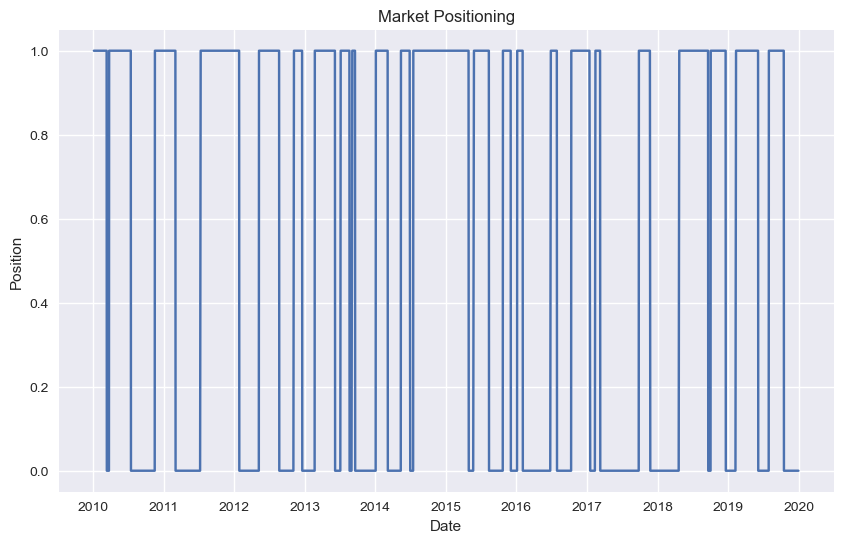

In [62]:
#Plot the market positions
plt.figure(figsize = (10,6))
plt.title("Market Positioning")
plt.xlabel("Date")
plt.ylabel("Position")
plt.plot(pricing_data['Band Position'])

In [65]:
#Calculate the returns on the data
pricing_data['Returns'] = np.log(pricing_data['Pricing'] / pricing_data['Pricing'].shift(1))

In [66]:
#Calculate the performance on the strategy data
pricing_data['Strategy'] = pricing_data['Band Position'].shift(1) * pricing_data['Returns']

In [67]:
#Compute the cummulative returns from the returns dataset
pricing_data['Cummulative Strategy'] = pricing_data['Strategy'].cumsum().apply(np.exp).apply(np.exp)
pricing_data['Cummulative Returns'] = pricing_data['Returns'].cumsum().apply(np.exp)

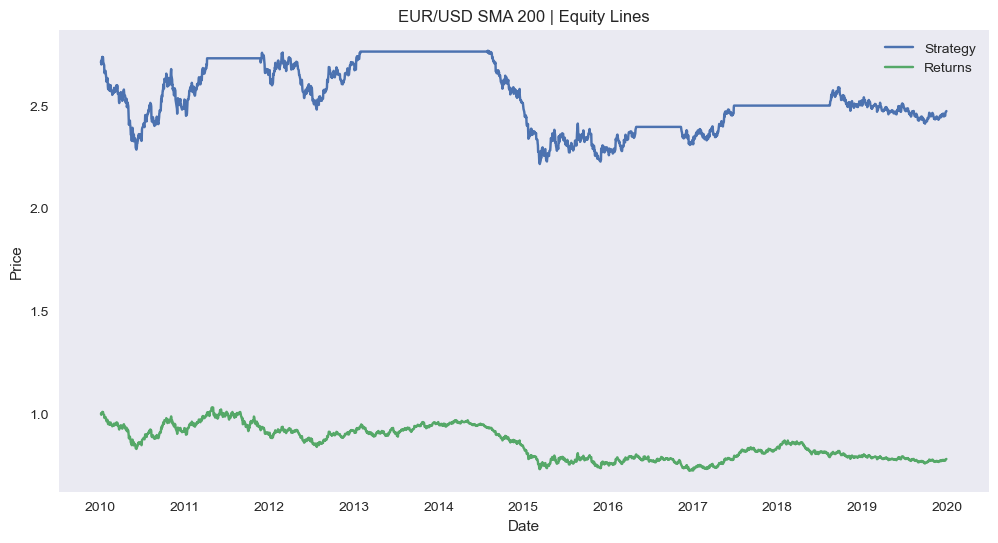

In [68]:
#Plot the figures with the trading signals
plt.figure(figsize = (12,6))
plt.title("EUR/USD SMA 200 | Equity Lines")
plt.plot(pricing_data['Cummulative Strategy'], label = "Strategy")
plt.plot(pricing_data['Cummulative Returns'], label = "Returns")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper right')
plt.grid()
plt.show()